<a href="https://colab.research.google.com/github/heli3199/Artificial-Intelligence/blob/main/Assignment_06_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 570 Assignment 6 Exercise






Your Name: Heliben Parikh

## Exercise 1: Creating an image denoiser using a CNN autoencoder. (30 points)
In this exercise you are trying to build a autoencoder with CNN layers that can denoise images. 

### Task 1: Create additive noise transform
1. Add code to `AddGaussianNoise` transform class that will:
  * Add additive Gaussian noise to the batch of input images (i.e add noise with gaussian distribution on each pixel). The noise for every pixel should have mean value 0 and standard deviation of 0.3, i.e $ \epsilon \sim N(0, 0.3)$.
  * Clip the values to be between 0 and 1 again as they may be outside the range for pixel values after adding Gaussian noise.
2. Plot the first 3 training images and their noisy counterparts in a 2x3 subplot with appropriate titles, figure size, label, etc.

In this task, we concatenate the original dataset and noisy dataset and get a single dataloader. You should be careful with what you load at each iteration. In a more general case, there are many ways of dealing with multiple datasets. For example, you can create separate dataloaders and use ``zip`` to load samples from them. Here is a post discussing how to use ``zip`` [https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1](https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1). 

In [ ]:
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np

class AddGaussianNoise(object):

  ###########################   <YOUR CODE>  ############################
  def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
  def __call__(self, tensor):
        tensor1 = tensor + torch.randn(tensor.size()) * self.std + self.mean
        return (np.clip(tensor1, 0,1))

  #########################  <END YOUR CODE>  ############################


transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

print(torch.max(train_dataset_noisy.__getitem__(0)[0]).item())
print(torch.min(train_dataset_noisy.__getitem__(0)[0]).item())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

1.0
0.0


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


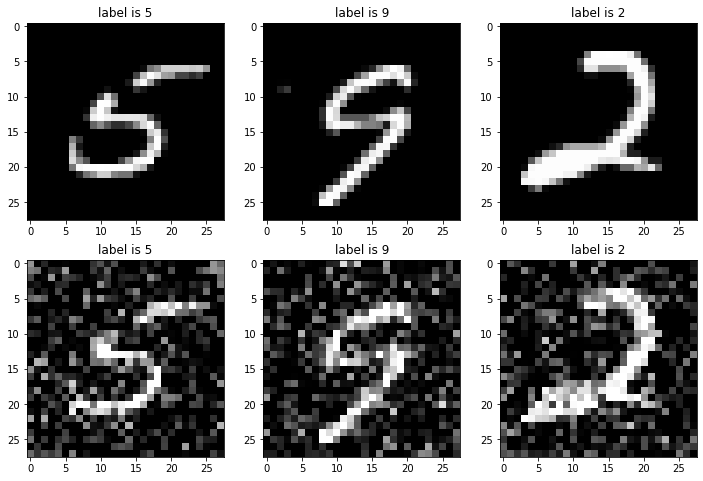

In [ ]:
class ConcatDataset(torch.utils.data.Dataset):
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i][0] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)


batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)

###########################   <YOUR CODE>  ############################
# Plot the first 3 training images with corresponding noisy images 
trainloader1 = torch.utils.data.DataLoader(train_dataset_original,
                      batch_size=batch_size_train, shuffle=False)
trainloader2 =torch.utils.data.DataLoader(train_dataset_noisy,
                      batch_size=batch_size_train, shuffle=False)

from itertools import cycle
for item1, item2 in zip(trainloader1, cycle(trainloader2)):
    image_batch1, labels1 = item1
    image_batch2, labels2 = item2

fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,8)

for idx in range(3):
  ax[0,idx].imshow(image_batch1[idx][0], cmap='gray')
  ax[0,idx].set_title(f'label is {labels1[idx]}')
  ax[1,idx].imshow(image_batch2[idx][0], cmap='gray')
  ax[1,idx].set_title(f'label is {labels2[idx]}')

fig.show()

#########################  <END YOUR CODE>  ############################

### Task 2: Create and train a denoising autoencoder
1. Build an autoencoder neural network structure with encoders and decoders that is a little more complicated than in the instructions. You can also create the network to have convolutional or transpose convolutional layers. (You can follow the instructions code skeleton with a key difference of using convolutional layers).
2. Move your model to GPU so that you can train your model with GPU. (This step can be simultaneously implemented in the above step)
3. Train your denoising autoencoder model with appropriate optimizer and **MSE** loss function. The loss function should be computed between the output of the noisy images and the clean images, i.e., $L(x, g(f(\tilde{x})))$, where $\tilde{x} = x + \epsilon$ is the noisy image and $\epsilon$ is the Gaussian niose. You should train your model with enough epochs so that your loss reaches a relatively steady value. **Note: Your loss on the test data should be lower than 20.** You may have to experiment with various model architectures to achieve this test loss.
4. Visualize your result with a 3 x 3 grid of subplots. You should show 3 test images, 3 test images with noise added, and 3 test images reconstructed after passing your noisy test images through the DAE.

In [ ]:
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')

We are using device name "cuda"


In [ ]:
###########################   <YOUR CODE>  ############################
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class our_AE(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=1),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        #self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(22 * 22 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim),
            nn.ReLU(True)
        )

        ###Decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 22 * 22 * 32),
            nn.ReLU(True)     
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 22, 22))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=1)
        )
        
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = x.view(-1,22*22*32)
        x = self.encoder_lin(x)
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        # print(x.shape)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x
d=16
AE = our_AE(encoded_space_dim=d,fc2_input_dim=128).to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-4)
loss_fn = nn.MSELoss(reduction='sum')

def train(epoch, device):

  AE.train() # we need to set the mode for our model

  for batch_idx, (noisy,original) in enumerate(train_loader): # Note that we do not need the labels

    optimizer.zero_grad()
    images = noisy.to(device)
    original =original.to(device)
    output = AE(images)
    loss = loss_fn(output, original) # Here is a typical loss function (Mean square error)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

  AE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for noisy,original in test_loader:
      images = noisy.to(device)
      original =original.to(device)
      output = AE(images)
      test_loss += loss_fn(output, original).item()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 5

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)
#########################  <END YOUR CODE>  ############################

Epoch 1: [0/60000] Loss: 180.37155151367188
Epoch 1: [6400/60000] Loss: 73.69286346435547
Epoch 1: [12800/60000] Loss: 53.39763641357422
Epoch 1: [19200/60000] Loss: 43.5213508605957
Epoch 1: [25600/60000] Loss: 38.642581939697266
Epoch 1: [32000/60000] Loss: 32.96404266357422
Epoch 1: [38400/60000] Loss: 30.729446411132812
Epoch 1: [44800/60000] Loss: 26.245512008666992
Epoch 1: [51200/60000] Loss: 28.175968170166016
Epoch 1: [57600/60000] Loss: 26.040626525878906
Test result on epoch 1: Avg loss is 24.8242609375
Epoch 2: [0/60000] Loss: 27.059669494628906
Epoch 2: [6400/60000] Loss: 22.0947265625
Epoch 2: [12800/60000] Loss: 22.375614166259766
Epoch 2: [19200/60000] Loss: 20.394563674926758
Epoch 2: [25600/60000] Loss: 21.986770629882812
Epoch 2: [32000/60000] Loss: 21.37670135498047
Epoch 2: [38400/60000] Loss: 18.281583786010742
Epoch 2: [44800/60000] Loss: 19.294235229492188
Epoch 2: [51200/60000] Loss: 18.10660171508789
Epoch 2: [57600/60000] Loss: 20.923049926757812
Test result 

torch.Size([1000, 1, 28, 28]) torch.Size([1000, 1, 28, 28])


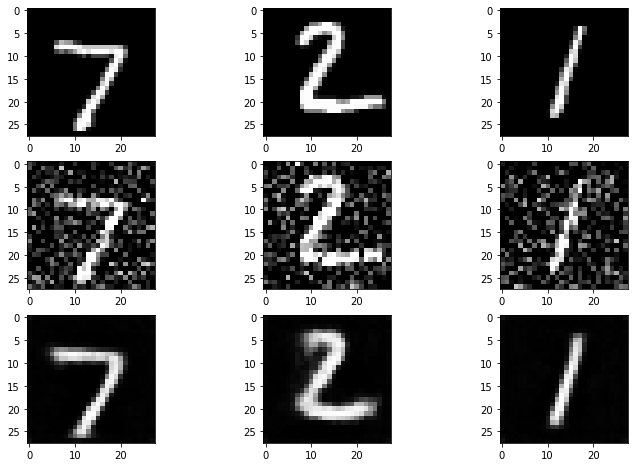

In [ ]:
import matplotlib.pyplot as plt

batch_idx, (images,images1) = next(enumerate(test_loader))
images = images.to(device)
output = AE(images).cpu().detach()
images = images.cpu()

print(images.size(), output.size())

fig, ax = plt.subplots(3,3)
fig.set_size_inches(12,8)

for idx in range(3):
  ax[0,idx].imshow(images1[idx][0], cmap='gray')
  ax[1,idx].imshow(images[idx][0], cmap='gray')
  ax[2,idx].imshow(output[idx][0], cmap='gray')

fig.show()

## Exercise 2: Build a variational autoencoder(VAE) that can generate MNIST images (70 points)

### Task 0: Setup
1. Import necessary packages
2. Load the MNIST data as above.
3. Specify the device.

In [ ]:
###########################   <YOUR CODE>  ############################
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


transform= torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
batch_size_train, batch_size_test = 64, 1000
train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size_test, shuffle=False)

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')
#########################  <END YOUR CODE>  ############################

We are using device name "cuda"


### Task 1: VAE Loss function
Construct your loss function. The loss function for VAE is a little bit difficult:
$$
\begin{aligned}
\textbf{NegativeELBO}(x, g, f) &= \mathbb{E}_{q_f}[-\log p_g(x|z)] + KL(q_f(z|x), p_g(z))\\
 &= \text{ReconstructionLoss} + \text{Regularizer}
\end{aligned}
$$
In this exercise, you will build the VAE (variational autoencoder) model satisfying following conditions which simplifies the computation of loss function:
1. $p_g(z)$ is a standard normal distribution.
2. $q_f(z|x)$ is a multivariate Gaussian with trainable mean and variance along each dimension.
3. The output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.

While we discussed the Gaussian distribution in class, here we assume the output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.
The value of the pixel corresponds to the average of the Bernoulli distribution.
This loss can be seen in Appendix C.1 of the original VAE paper: https://arxiv.org/pdf/1312.6114.pdf.
With such assumpition, the reconstruction loss can be calculated using the binary-cross-entropy loss between the original images and the output of the VAE.
See [torch.nn.functional.binary_cross_entropy](https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy).
You should use the sum reduction of the loss to sum the loss over all the pixels. 

The second part is the KL-Divergence between your model's approximate posterier $q_f(z|x)$ and the model prior $p_g(z)$.
If we assume $p_g(z)$ is a standard normal distribution and $q_f(z|x)$ is a Gaussian with unknown mean and variance, then this KL divergence can be computed in closed form (see Appendix B of original VAE paper above):
$KL(q_f(z|x), p_g(z)) = -\frac{1}{2}\sum_{j=1}^d(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2)$. 


Your task here is to write a function `vae_loss` that takes the value of your model's output, the original images, mu, and log_var (i.e., the $\log(\sigma_j^2)$ term), and returns the the reconstruction loss and the KL loss terms **separately** (i.e., the function should return two loss arrays). To visualize these losses separately in a later task, you will need the reconstruction loss and KL loss separated.


In [ ]:
def vae_loss(output, mu, log_var, images):
  """
  :param output: this the output of your neural network
  :param mu: this is the mu from the latent space
  :param log_var: this is the log_var from the latent space
  :param images: this is the original sets of images

  """
  ###########################   <YOUR CODE>  ############################
  reconstruct_loss = nn.functional.binary_cross_entropy(output, images, reduction='sum')
  KLD = - 0.5 * torch.sum(1+ log_var - mu.pow(2) - log_var.exp())
  ELBO = reconstruct_loss + KLD
  return ELBO, reconstruct_loss,KLD

  #########################  <END YOUR CODE>  ############################


### Task 2: VAE model
Build the VAE (variational autoencoder) model based on the instructions given below and in the comments.
* Inside the `reparameterize` function you job is to output a latent vector. You should first calculate the standard deviation `std` from the log variance variable `log_var` (i.e., compute $\sigma$ from $\log (\sigma^2)$, then generate the vector in Gaussian distribution with `mu` and `std`.  **Importantly**, this should use the reparametrization trick so that we can backpropagate through this random step.

* Inside the `forward` function you should extract the `mu` and `log_var` from the latent representation after the encoder. The output of encoder should be in the dimension ` [batch_size x 2 x latent_feature]`, which includes a mean and log variance for each latent feature and for each instance in the batch.  Remember that in VAEs, the encoder outputs the parameters of the latent distribution. Note that the second dimension has value 2, so you need to split this tensor into two components, one called `mu` and the other called `log_var`---which will be fed into reparameterize.



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class our_VAE(nn.Module):
  def __init__(self, latent_feature = 16): # you can use any number of latent features you want in the training
    super(our_VAE, self).__init__()

    self.latent_feature = latent_feature
    
    ###########################   <YOUR CODE>  ############################
    # define the transformations for your encoder and decoder
    #Encoder
    self.fc1 = nn.Linear(784, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, latent_feature*2) 
    #Decoder
    self.fc4 = nn.Linear(latent_feature, 256)
    self.fc5 = nn.Linear(256,512)
    self.fc6 = nn.Linear(512, 784)
       
    #########################  <END YOUR CODE>  ############################

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space

    You should return a sample with gaussian distribution N(mu, var) using 
    the reparameterization trick.
    """
    ###########################   <YOUR CODE>  ############################
    std = torch.exp(0.5*log_var)
    epsilon = torch.randn_like(std).to(device)             # sampling epsilon        
    sample = mu + epsilon*std                         # reparameterization trick
    
    #########################  <END YOUR CODE>  ############################
    return sample
  def encoder(self, x):
    """
    :param x: input distribution

    You should first compute the parameters mu and log_var for Gaussian distribution q(z|x), and 
    then get samples from q(z|x) using the reparameterize function you just created.
    The final output should include mu, log_var and z~q(z|x)
    """
    ###########################   <YOUR CODE>  ############################
    x=x.view(-1,784)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x= self.fc3(x)
    x=x.view(-1,2,self.latent_feature)
    mu=x[:,0,:]
    log_var=x[:,1,:]
    
    z = self.reparameterize(mu, log_var)    
    #########################  <END YOUR CODE>  ###########################

    return mu, log_var, z

  def decoder(self, z):
    """
    :param z: latent distribution

    You should compute the output x given latent samples z
    """

    ###########################   <YOUR CODE>  ############################
    
    x = F.relu(self.fc4(z))
    x = F.relu(self.fc5(x))
    x = torch.sigmoid(self.fc6(x))
    x = x.view(-1,1,28,28)

    #########################  <END YOUR CODE>  ###########################
    return x


  
  def forward(self, x):
    """
    :param x: input variables

    You should compute the output images using the encoder and decoder you just defined.
    Remember to return the mu and log_var for the computation of loss.
    """

    ###########################   <YOUR CODE>  ############################
    mu, log_var, z= self.encoder(x)
    x= self.decoder(z)

    #########################  <END YOUR CODE>  ###########################
        
    return x, mu, log_var

### Task 3: Train and visualize output
1. Train your model with an appropriate optimizer and the above loss function. You should train your model with enough epochs so that your loss reaches a relatively steady value.

2. Visualize your result. You should **show three pairs of images** where each pair consists of an original test image and its VAE reconstructed version.

3. Keep track of the loss. You should save the negative ELBO, Reconstruction Loss and KL Divergence Loss after every 10 batches in the trainining and **create a plot with three curves** using [matplotlib.pyplot.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). Each curve should correpond to one of the losses. The x-axis will be the number of batches divided by 10 and the y-axis will be the loss. **Make sure you clearly specify the legend, x-label and y-label.**

**Note:** It is always a good idea to keep track of the loss in the process of training to help you understand what is happening during training.

In [ ]:
###########################   <YOUR CODE>  ############################
model = our_VAE(latent_feature=16).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(epoch, device):

  model.train() # we need to set the mode for our model

  for batch_idx, (images, _) in enumerate(train_loader): # Note that we do not need the labels

    optimizer.zero_grad()
    images = images.to(device)
    output, mu, log_var = model(images)
    # print(output.shape, images.shape)
    loss, reconstruct_loss,KLD= vae_loss(output, mu, log_var, images) 
    loss.backward()
    optimizer.step()
    
    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      r_loss.append(reconstruct_loss.item()/batch_size_train)
      k_loss.append(KLD.item()/batch_size_train)
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 400 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

  model.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, _ in test_loader:
      images = images.to(device)
      output, mu, log_var = model(images)
      loss, reconstruct_loss,KLD= vae_loss(output, mu, log_var, images)
      test_loss += vae_loss(output, mu, log_var, images)[0]
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')
#########################  <END YOUR CODE>  ###########################
train_losses = []
train_counter = []
test_losses = []
test_counter = []
r_loss=[]
k_loss=[]
max_epoch = 20

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)

Epoch 1: [0/60000] Loss: 545.8079223632812
Epoch 1: [25600/60000] Loss: 199.0081787109375
Epoch 1: [51200/60000] Loss: 189.776123046875
Test result on epoch 1: Avg loss is 181.85104370117188
Epoch 2: [0/60000] Loss: 176.45889282226562
Epoch 2: [25600/60000] Loss: 166.87042236328125
Epoch 2: [51200/60000] Loss: 148.06951904296875
Test result on epoch 2: Avg loss is 150.8218536376953
Epoch 3: [0/60000] Loss: 153.87831115722656
Epoch 3: [25600/60000] Loss: 143.5237274169922
Epoch 3: [51200/60000] Loss: 149.312744140625
Test result on epoch 3: Avg loss is 136.5330047607422
Epoch 4: [0/60000] Loss: 139.3585205078125
Epoch 4: [25600/60000] Loss: 134.38172912597656
Epoch 4: [51200/60000] Loss: 123.73007202148438
Test result on epoch 4: Avg loss is 128.69854736328125
Epoch 5: [0/60000] Loss: 123.74000549316406
Epoch 5: [25600/60000] Loss: 129.94358825683594
Epoch 5: [51200/60000] Loss: 130.12338256835938
Test result on epoch 5: Avg loss is 123.92798614501953
Epoch 6: [0/60000] Loss: 125.318359

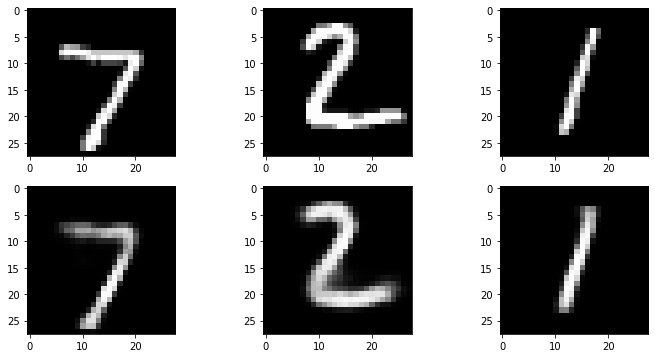

In [ ]:
import matplotlib.pyplot as plt

batch_idx, (images, _) = next(enumerate(test_loader))
images = images.to(device)
output = model(images)[0].cpu().detach()
images = images.cpu()

fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,6)

for idx in range(3):
  ax[0,idx].imshow(images[idx][0], cmap='gray')
  ax[1,idx].imshow(output[idx][0], cmap='gray')

fig.show()

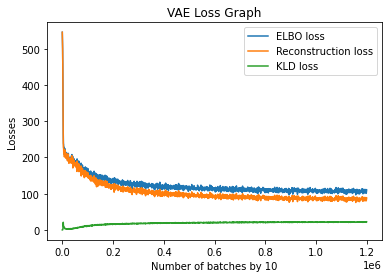

In [ ]:
plt.plot(train_counter, train_losses)
plt.plot(train_counter, r_loss)
plt.plot(train_counter,k_loss)
plt.xlabel("Number of batches by 10")
plt.ylabel("Losses")
plt.title("VAE Loss Graph")
plt.legend(['ELBO loss','Reconstruction loss','KLD loss'])
plt.show()

### Task 4.1: Latent space of VAE

The latent space will change over time during training as the networks learn which features of the input are most important.  In the beginning, the reconstruction error will be poor and the latent space will be mixed up (i.e., it has not identified good features for dimensionality reduction and then reconstruction).  However, as it continues to train, the space will begin to show some structure (similar to in PCA) as it finds features that enable good reconstruction even after adding a little noise. Therefore, to get some intuition about this process, in this task, you will visualize how latent space changes in the process of training with the given function ``plot_latent``.

1. For better visualization, create a VAE with ``latent_features=2``.
2. Similar to task 3, train the VAE for a few epochs. But you will need to plot the latent distribution using the provided ``plot_latent`` function below at initialization (so you can see what the latent space looks like at initialization) AND after **each** epoch. You should use the **test** data for plotting this visualization task.


In [ ]:
def plot_latent(vae, data_loader, num_batches=2):
  with torch.no_grad():
    for ibx, (images,label) in enumerate(data_loader):
      _,_,z = vae.encoder(images.to(device))
      z = z.to('cpu').detach().numpy()
      plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10',s=1)
      if ibx > num_batches:
        break
  plt.colorbar()
  plt.show()

Epoch 1: [0/60000] Loss: 543.2313232421875
Epoch 1: [6400/60000] Loss: 224.46556091308594
Epoch 1: [12800/60000] Loss: 221.58441162109375
Epoch 1: [19200/60000] Loss: 207.26226806640625
Epoch 1: [25600/60000] Loss: 187.71388244628906
Epoch 1: [32000/60000] Loss: 195.0367431640625
Epoch 1: [38400/60000] Loss: 191.0512237548828
Epoch 1: [44800/60000] Loss: 188.8931884765625
Epoch 1: [51200/60000] Loss: 173.0486602783203
Epoch 1: [57600/60000] Loss: 181.70440673828125
Test result on epoch 1: Avg loss is 176.7002716064453


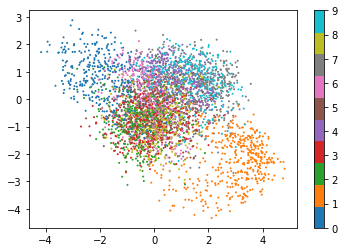

Epoch 2: [0/60000] Loss: 181.9329376220703
Epoch 2: [6400/60000] Loss: 186.60324096679688
Epoch 2: [12800/60000] Loss: 167.3376007080078
Epoch 2: [19200/60000] Loss: 174.708251953125
Epoch 2: [25600/60000] Loss: 169.52769470214844
Epoch 2: [32000/60000] Loss: 159.16845703125
Epoch 2: [38400/60000] Loss: 170.5113525390625
Epoch 2: [44800/60000] Loss: 163.58303833007812
Epoch 2: [51200/60000] Loss: 185.7025146484375
Epoch 2: [57600/60000] Loss: 171.6029052734375
Test result on epoch 2: Avg loss is 169.1118927001953


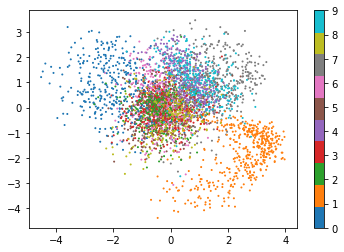

Epoch 3: [0/60000] Loss: 174.5351104736328
Epoch 3: [6400/60000] Loss: 168.04624938964844
Epoch 3: [12800/60000] Loss: 164.96356201171875
Epoch 3: [19200/60000] Loss: 161.54205322265625
Epoch 3: [25600/60000] Loss: 172.43228149414062
Epoch 3: [32000/60000] Loss: 167.9175262451172
Epoch 3: [38400/60000] Loss: 163.51773071289062
Epoch 3: [44800/60000] Loss: 169.80560302734375
Epoch 3: [51200/60000] Loss: 168.95843505859375
Epoch 3: [57600/60000] Loss: 156.34877014160156
Test result on epoch 3: Avg loss is 166.4451904296875


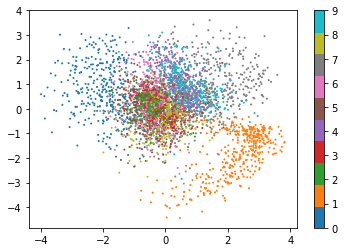

Epoch 4: [0/60000] Loss: 157.45884704589844
Epoch 4: [6400/60000] Loss: 165.88894653320312
Epoch 4: [12800/60000] Loss: 179.14154052734375
Epoch 4: [19200/60000] Loss: 165.01953125
Epoch 4: [25600/60000] Loss: 171.6676788330078
Epoch 4: [32000/60000] Loss: 155.9178466796875
Epoch 4: [38400/60000] Loss: 164.84173583984375
Epoch 4: [44800/60000] Loss: 160.52423095703125
Epoch 4: [51200/60000] Loss: 162.343505859375
Epoch 4: [57600/60000] Loss: 166.73013305664062
Test result on epoch 4: Avg loss is 164.5260772705078


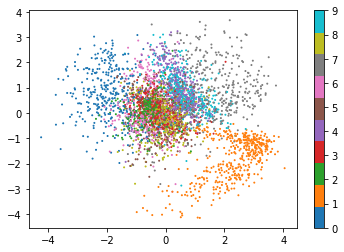

Epoch 5: [0/60000] Loss: 166.2377166748047
Epoch 5: [6400/60000] Loss: 169.1566162109375
Epoch 5: [12800/60000] Loss: 168.2731170654297
Epoch 5: [19200/60000] Loss: 158.34432983398438
Epoch 5: [25600/60000] Loss: 162.15785217285156
Epoch 5: [32000/60000] Loss: 168.64906311035156
Epoch 5: [38400/60000] Loss: 156.5424346923828
Epoch 5: [44800/60000] Loss: 158.84576416015625
Epoch 5: [51200/60000] Loss: 150.6558380126953
Epoch 5: [57600/60000] Loss: 173.2532501220703
Test result on epoch 5: Avg loss is 161.9752197265625


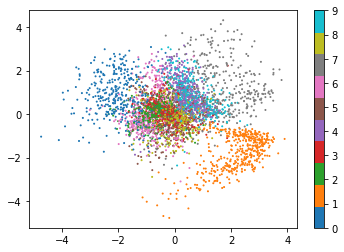

In [ ]:
###########################   <YOUR CODE>  ############################
model1 = our_VAE(latent_feature=2).to(device)
optimizer = optim.Adam(model1.parameters(), lr=1e-4)

def train(epoch, device):

  model1.train() # we need to set the mode for our model

  for batch_idx, (images, _) in enumerate(train_loader): # Note that we do not need the labels

    optimizer.zero_grad()
    images = images.to(device)
    output, mu, log_var = model1(images)
    # print(output.shape, images.shape)
    loss, reconstruct_loss,KLD= vae_loss(output, mu, log_var, images) 
    loss.backward()
    optimizer.step()
    
    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      r_loss.append(reconstruct_loss.item()/batch_size_train)
      k_loss.append(KLD.item()/batch_size_train)
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

  model1.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, _ in test_loader:
      images = images.to(device)
      output, mu, log_var = model1(images)
      loss, reconstruct_loss,KLD= vae_loss(output, mu, log_var, images)
      test_loss += vae_loss(output, mu, log_var, images)[0]
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')
#########################  <END YOUR CODE>  ###########################
train_losses = []
train_counter = []
test_losses = []
test_counter = []
r_loss=[]
k_loss=[]
max_epoch = 5

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)
  plot_latent(model1, test_loader,2)
#########################  <END YOUR CODE>  ###########################

### Task 4.2 Interpolation of latent space

Interpolation can be quite useful for autoencoder models. For example, by linearly interpolating (or mixing) codes in latent space and decoding the result, the autoencoder can produce a more **semantically meaningful**
combination of the corresponding datapoints than linear interpolation in the raw pixel space. 
Besides, in some cases, interpolation experiments can show that the model has learned a latent space with a particular structure. Specifically, if interpolation between points in the latent space shows a smooth semantic warping in the original image space, then the visualization may suggest that similar points are semantically clustered in the latent space.

In this task, you will do a simple experiment to see the difference between linear interpolation in the latent space and the original data space (raw pixels).
1. With a trained model and test data, sample one $z\sim q(z|x)$ corresponding to label 0 and 1 separately (two samples in total); this can be done by passing test samples (with labels 0 and 1 respectively) through the encoder. These two latent samples will be denoted $z_0$ and $z_1$ respectively.

2. Compute the linear interpolation of $x_0$ and $x_1$ in the following way: $x'=\alpha x_1 + (1-\alpha)x_0$ where $\alpha = 0, 0.1, 0.2, \dots, 0.9, 1.0$. **Plot** all $x'$ images you get in a 1x11 grid.

3. Compute the latent linear interpolation of $z_0$ and $z_1$ to get $z'$ in a similar way. Then, reconstruct the $x'$ corresponding to each $z'$ using the decoder. **Plot** all $x'$ images you get in a 1x11 grid.

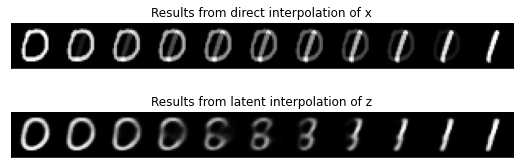

In [ ]:
###########################   <YOUR CODE>  ############################
def interpolate(model, x_0, x_1):
    z_0 = model.encoder(x_0)[2]
    z_1 = model.encoder(x_1)[2]
    z = torch.stack([z_1*t + z_0*(1-t) for t in np.arange(0, 1.1, 0.1)])
    interpolate_list = model.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()
    xx = torch.stack([x_1*t + x_0*(1-t) for t in np.arange(0, 1.1, 0.1)])
    xx = xx.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, 11*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    
    img1 = np.zeros((w, 11*w))
    for i,x_hat1 in enumerate(xx):
      img1[:, i*w:(i+1)*w] = x_hat1.reshape(28, 28)
    f,ax=plt.subplots(2,1)
    f.set_size_inches(9,3)
    ax[0].imshow(img1,cmap='gray')
    ax[0].set_title("Results from direct interpolation of x")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].imshow(img,cmap='gray')
    ax[1].set_title("Results from latent interpolation of z")
    ax[1].set_xticks([])
    ax[1].set_yticks([])

x, y = test_loader.__iter__().next() 
x_1 = x[y == 1][1].to(device) 
x_0 = x[y == 0][1].to(device) 

interpolate(model, x_0, x_1)  
#########################  <END YOUR CODE>  ###########################